# 简单理解 Density Fitting RHF 自洽场

这一篇文章我们简单讨论 PySCF 下的 Density Fitting (DF) 的实现过程。

In [1]:
%matplotlib notebook

import numpy as np
import scipy
from functools import partial
import matplotlib.pyplot as plt

from pyscf import gto, scf, df

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(8, linewidth=150, suppress=True)

在开始这篇文章前，我们需要定义用于将以向量储存的下三角矩阵转为普通对称矩阵的函数 `tril_to_symm`。若同时传入多个下三角矩阵，那么我们也会同样地传出多个对应的对称矩阵。

In [2]:
def tril_to_symm(tril: np.ndarray):
    tril = np.asarray(tril)
    if len(tril.shape) > 1:
        return np.array([tril_to_symm(mat) for mat in tril])
    dim = int(np.floor(np.sqrt(tril.size * 2)))
    if dim * (dim + 1) / 2 != tril.size:
        raise ValueError("Size " + str(tril.size) + " is probably not a valid lower-triangle matrix.")
    indices_tuple = np.tril_indices(dim)
    iterator = zip(*indices_tuple)
    symm = np.empty((dim, dim))
    for it, (row, col) in enumerate(iterator):
        symm[row, col] = tril[it]
        symm[col, row] = tril[it]
    return symm

我们也需要指定我们的分子体系。这里使用一个非常不对称的双氧水作为例子：

In [3]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "def2-tzvp"
mol.verbose = 0
mol.build()

## PySCF 自洽场

### PySCF 普通 RHF

在我们跑 DF RHF 前，我们先跑一下普通的 RHF，以作对比。

In [4]:
scf_normal = scf.RHF(mol)
scf_normal.run()
scf_normal.e_tot

-150.73664182977006

### PySCF DF RHF

在 PySCF 中，设置 DF 一般至少需要两步：首先需要让 RHF 方法成为 DF 的；其次需要定义 DF 基组。

In [5]:
### PySCF 普通 RHF
scf_df = scf.RHF(mol).density_fit()
scf_df.with_df.auxbasis = "def2-tzvp-jkfit"
scf_df.run()
scf_df.e_tot

-150.73658270520568

我们应当能发现 DF RHF 与普通 RHF 的能量还是有所差别的；尽管差别不大但 $10^{-4}$ 级别的差别在小体系的量化计算中应当认为是不可忽略的。

In [6]:
scf_df.e_tot - scf_normal.e_tot

5.912456438750269e-05

## 重现 PySCF DF RHF 能量

这里我们会通过上面 DF RHF 已经收敛的结果，来计算上述双氧水体系的总能量。

### DF 双电子积分

我们需要先定义 DF 基组下的 PySCF 分子类 `auxmol`；它将为我们提供我们所需要的 DF 双电子积分。

In [7]:
auxmol = mol.copy()
auxmol.basis = "def2-tzvp-jkfit"
auxmol.build()

<div class="alert alert-info">

**提醒**

事实上，PySCF 也提供了 `scf_df.with_df.auxmol` 给出 DF 的双电子积分，并且这才是最合适的用法。但在我的理解范围内，上述的直接定义 `auxmol` 的方法几乎是等价的。

</div>

在 DF RHF 的过程中，需要使用到 DF 生成的双电子积分的地方只有库伦矩阵 (J 矩阵) 与交换矩阵 (K 矩阵)。我们知道普通 RHF 的计算耗时受制于四中心双电子 (4c2e) ERI 积分，因此计算复杂度为 $O(N^4)$。而 DF RHF 之所以快，就是因为它能将 ERI 积分转化为三中心双电子 (3c2e) 积分与双中心双电子 (2c2e) 积分，从而将计算复杂度转为 $O(N^3)$。

<div class="alert alert-info">

**记号定义**

这里采用我自己习惯的记号，以及 <cite data-cite="Sherrill.Note.DF.2010">Sherrill, Lab-note</cite> 的记号行文。大致但重要的记号定义如下：

* $\mu, \nu, \kappa, \lambda$ 代表原子轨道

* $i, j, k, l$ 代表占据轨道

* $a, b, c, d$ 代表非占轨道

* $p, q, r, s$ 代表任意分子轨道

* $P, Q$ 代表 DF 轨道

* 在表达轨道函数形式时，原子、分子轨道用 $\phi$ 表达，而 DF 轨道用 $\chi$ 表达

* $J_{\mu \nu} [R_{\kappa \lambda}]$ 表示在电子密度为 $R_{\kappa \lambda}$ 下的 J 积分。类似地，还有 K 积分 $K_{\mu \nu} [R_{\kappa \lambda}]$。

* $(\mu \nu | P)$ 代表 3c2e 积分，$J_{PQ}$ 代表 2c2e 积分。2c2e 积分的符号与 J 积分相同；但通过角标应当可以区分两者，免去歧义。

</div>

我们先描述 2c2e 积分 $J_{PQ}$ `int2c2e`。2c2e 积分从定义上是

$$
J_{PQ} = \iint \chi_P (\boldsymbol{r}_1) \frac{1}{r_{12}} \chi_Q (\boldsymbol{r}_2) \, \mathrm{d} \boldsymbol{r}_1 \, \mathrm{d} \boldsymbol{r}_2
$$

尽管下面的类似于 Dirac 的记号并不严谨，但在简单分析问题时，下述记号仍然是方便的：

$$
J_{PQ} = ( P | \frac{1}{r_{12}} | Q )
$$

之所以说是不严格的，是因为在多轨道下，Dirac 记号在算符左右的部分应当需要在电子坐标上是一一对应的，因此 $( P 1 | r_{12}^{-1} | 1 Q )$ 可能更合理一些。

在 PySCF 中，2c2e 积分 `int2c2e` 可以很容易地通过 `intor` 生成；这个函数也可以生成绝大多数普通的 SCF 计算过程中所需要使用的积分。需要注意的是，这里使用的基组是 DF 基组，因此分子类也应当使用的是 `auxmol`：

In [8]:
int2c2e = auxmol.intor("int2c2e")
int2c2e.shape

(190, 190)

对于 3c2e 积分 $(\mu \nu | P)$ `int3c2e`，其定义也是类似的：

$$
(\mu \nu | P) = \iint \phi_\mu (\boldsymbol{r}_1) \phi_\nu (\boldsymbol{r}_1) \frac{1}{r_{12}} \chi_P (\boldsymbol{r}_2) \, \mathrm{d} \boldsymbol{r}_1 \, \mathrm{d} \boldsymbol{r}_2
$$

但对于 3c2e 积分 `int3c2e` 而言，由于其中混合了普通基组与 DF 基组，因此不能通过简单的 `intor` 来生成积分。我们使用 `df.incore.aux_e2` 来生成 $(\mu \nu | P)$：

In [9]:
int3c2e = df.incore.aux_e2(mol, auxmol)

该积分也可以不借助 `pyscf.df` 模块生成，但实现起来稍复杂一些。

### DF 积分模拟 4c2e ERI 积分

<div class="alert alert-info">

**提醒**

这篇文档仅在这一段不使用 Einstein Summation Convention。

</div>

我们指出，这些积分是通过下述过程来模拟 ERI 积分 $(\mu \nu | \kappa \lambda)$：

$$
(\mu \nu | \kappa \lambda) \simeq (\mu \nu | P) (\mathbf{J}^{-1})_{PQ} (Q | \kappa \lambda)
$$

我们用程序生成 4c2e 的 ERI 积分 $(\mu \nu | \kappa \lambda)$ `eri` 与 DF 积分生成的 ERI 积分 `df_eri`：

In [10]:
eri = mol.intor("int2e")
df_eri = np.einsum("uvP, PQ, klQ -> uvkl", int3c2e, np.linalg.inv(int2c2e), int3c2e)

之所以我们会用上式模拟 4c2e 的 ERI 积分，可以从下面不太严格的公式来看：

$$
\langle \mu \nu | r_{12}^{-1} | \kappa \lambda \rangle \simeq \sum_{PQ} \langle \mu \nu | r_{12}^{-1} | P \rangle \langle P | r_{12} | Q \rangle \langle Q | r_{12}^{-1} | \kappa \lambda \rangle
$$

上式利用到两次 Resolution of Identity (RI) 关系式

$$
1 \simeq \sum_P | P \rangle \langle P |
$$

我们目前还没有 $\langle P | r_{12} | Q \rangle$；但它也可以通过使用了一次 RI 关系式的表达式

$$
\delta_{PR} \simeq \langle P | R \rangle = \sum_{Q} \langle P | r_{12} | Q \rangle \langle Q | r_{12}^{-1} | R \rangle
$$

给出。实施上，$J_{QR} = \langle Q | r_{12}^{-1} | R \rangle$；若我们定义矩阵 $X_{PQ} = \langle P | r_{12} | Q \rangle$，那么上述公式的矩阵表达式将是

$$
\mathbf{I} \simeq \mathbf{X} \mathbf{J}
$$

其中，$\mathbf{I}$ 表示单位矩阵。因此，$\mathbf{X} \simeq \mathbf{J}^{-1}$。这就完成了近似表达式 $(\mu \nu | \kappa \lambda) \simeq (\mu \nu | P) (\mathbf{J}^{-1})_{PQ} (Q | \kappa \lambda)$ 的说明了。

之所以上面式子中都采用近似相等记号 $\simeq$，而不采用相等记号 $=$，是因为受计算能力影响，实践中的 RI 展开的函数基是有限的。若 RI 是使用无限函数基展开，原则上等号成立。

上面是理论上的推演；现在我们考察在双氧水体系下上述近似的有效性。我们将绘制一幅 ERI 概率分布图来表明这个问题。横坐标的含义是 ERI 积分数值的以 10 为底的对数；纵坐标的意义是 ERI 积分中，处在某一数量级时的概率密度 (PDF)。

In [11]:
bins =np.arange(-12, 1., 0.1)
histo_eri = np.histogram(np.log10(np.abs(eri).ravel() + 1e-20), bins=bins)
histo_df_eri = np.histogram(np.log10(np.abs(df_eri).ravel() + 1e-20), bins=bins)
histo_dev = np.histogram(np.log10(np.abs(df_eri - eri).ravel() + 1e-20), bins=bins)

In [12]:
prob_eri = histo_eri[0] / eri.size
prob_df_eri = histo_df_eri[0] / eri.size
prob_dev = histo_dev[0] / eri.size

<IPython.core.display.Javascript object>


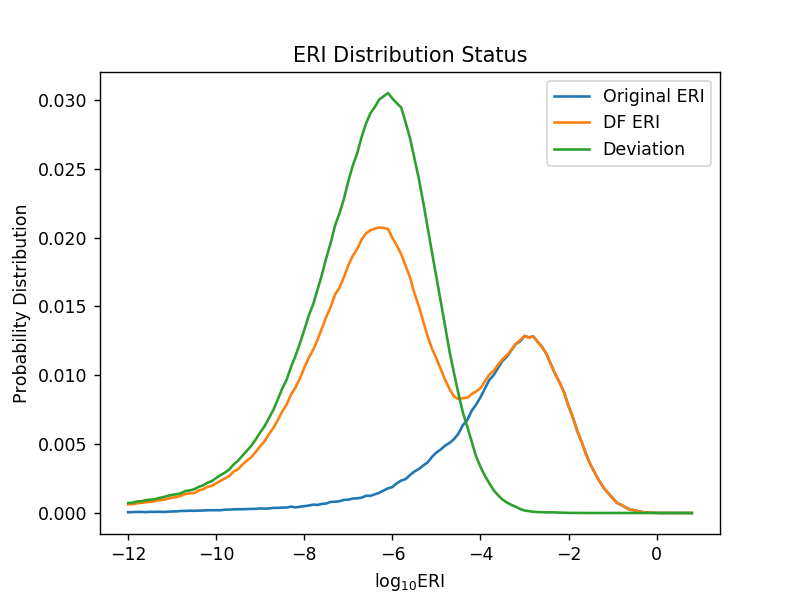

In [13]:
fig, ax = plt.subplots()

ax.plot(histo_eri[1][:-1], prob_eri, label="Original ERI")
ax.plot(histo_df_eri[1][:-1], prob_df_eri, label="DF ERI")
ax.plot(histo_dev[1][:-1], prob_dev, label="Deviation")

ax.set_xlabel("$\mathrm{log}_{10} \mathrm{ERI}$")
ax.set_ylabel("Probability Distribution")
ax.set_title("ERI Distribution Status")
ax.legend()

需要作补充说明的是，事实上不论是 DF ERI 或是 4c2e ERI，它们都有许多值为零，因此上述 PDF 图的积分在 $[-N, +N] \, (\forall N \in \mathscr{N}^{*})$ 区间的积分面积总小于 1；但这并不影响我们讨论。

我们能发现，在 ERI 积分中大于 $10^{-4}$ 大小的数值部分，DF ERI 积分与普通的 4c2e ERI 积分的分布是几乎相同的，意味着 DF ERI 把握住 4c2e ERI 积分的主要部分。但对于小于该数值的次要部分，DF ERI 并不能很好地对 4c2e ERI 积分作出近似。

### 重复 DF J 积分

首先，我们指出，我们目标的 DF J 积分并不与普通的 J 积分相同：

In [14]:
X = np.random.randn(mol.nao, mol.nao)
X += X.T

In [15]:
np.allclose(scf_normal.get_j(dm=X), scf_df.get_j(dm=X))

False

根据 J 积分的定义 $J_{\mu \nu} [X_{\kappa \lambda}] = (\mu \nu | \kappa \lambda) X_{\kappa \lambda}$，我们应当很容易地给出 DF J 积分的定义：

$$
J_{\mu \nu} [X_{\kappa \lambda}] \simeq (\mu \nu | P) (\mathbf{J}^{-1})_{PQ} (Q | \kappa \lambda) X_{\kappa \lambda}
$$

In [16]:
np.allclose(
    np.einsum("uvP, PQ, klQ, kl -> uv", int3c2e, np.linalg.inv(int2c2e), int3c2e, X),
    scf_df.get_j(dm=X)
)

True

但求逆运算一般来说是需要避免的。在 PySCF 默认的 DF 程序实践中，通常是采用 Cholesky 分解与线性方程组求解得到三角标张量 $V_{\mu \nu, P}$，随后再进行缩并。具体的过程大致如下：首先通过 Cholesky 分解给出 $(\mathbf{J}^{1/2})_{PQ}$ `int2c2e_half`：

$$
J_{PQ} = (\mathbf{J}^{1/2})_{PR} (\mathbf{J}^{1/2})_{QR}
$$

In [17]:
int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
np.allclose(np.einsum("PR, QR -> PQ", int2c2e_half, int2c2e_half), int2c2e)

True

随后通过求解 $(\mathbf{J}^{1/2})_{PQ} V_{\mu \nu, Q} = (\mu \nu | P)$，得到 $V_{\mu \nu, Q} = (\mathbf{J}^{-1/2})_{PQ} (\mu \nu | P)$ `V_df`；但注意到 $(\mu \nu)$ 一般是用作双下标的，但在求解方程的时候需要转换为同一维度。

In [18]:
V_df = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, auxmol.nao).T, lower=True)\
           .reshape(auxmol.nao, mol.nao, mol.nao).transpose((1, 2, 0))

由此，J 积分可以通过下式给出：

$$
J_{\mu \nu} [X_{\kappa \lambda}] = V_{\mu \nu, P} V_{\kappa \lambda, P} X_{\kappa \lambda}
$$

In [19]:
np.allclose(
    np.einsum("uvP, klP, kl -> uv", V_df, V_df, X),
    scf_df.get_j(dm=X)
)

True

K 积分也可以类似地给出。

### PySCF 的三角标张量 $V_{\mu \nu, P}$

事实上，PySCF 会储存三角标张量 $V_{\mu \nu, P}$。根据其 [文档](http://pyscf.org/pyscf/df.html#saving-loading-df-integral-tensor)，三角标张量储存于

In [20]:
scf_df.with_df._cderi.shape

(190, 2775)

储存下来的张量是两个维度，第一个维度是 DF 基组大小，第二个则是 $(\mu \nu)$ 双下标的下三角矩阵所给出的向量。现在我们将其展开为对称张量 `V_df_pyscf`：

In [21]:
V_df_pyscf = tril_to_symm(scf_df.with_df._cderi).transpose((1, 2, 0))

我们可以验证 PySCF 与我们所给出的 $V_{\mu \nu, P}$ 是等价的：

In [22]:
np.allclose(V_df, V_df_pyscf)

True

## DF RHF 自洽场

既然我们已经重复出 DF J/K 积分，那么我们就可以写一个简单但完整的 RHF 计算程序。

### 体系定义

In [23]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "def2-tzvp"
mol.verbose = 0
mol.build()

auxmol = mol.copy()
auxmol.basis = "def2-tzvp-jkfit"
auxmol.build()

In [24]:
natm = mol.natm
nao = nmo = mol.nao
nocc = mol.nelec[0]
nvir = nmo - nocc
so, sv, sa = slice(0, nocc), slice(nocc, nmo), slice(0, nmo)

nao_df = auxmol.nao

### 积分与能量定义

In [25]:
T = mol.intor("int1e_kin")
Vnuc = mol.intor("int1e_nuc")
H = T + Vnuc
S = mol.intor("int1e_ovlp")

int2c2e = auxmol.intor("int2c2e")
int2c2e.shape
int3c2e = df.incore.aux_e2(mol, auxmol)

int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
V_df = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, nao_df).T, lower=True)\
           .reshape(nao_df, nao, nao).transpose((1, 2, 0))

In [26]:
def gen_J(X):
    return np.einsum("uvP, klP, kl -> uv", V_df, V_df, X)
    
def gen_K(X):
    return np.einsum("ukP, vlP, kl -> uv", V_df, V_df, X)
    
def gen_F(X):
    return H + gen_J(X) - 0.5 * gen_K(X)

def gen_energy_elec(D):
    return ((H + 0.5 * gen_J(D) - 0.25 * gen_K(D)) * D).sum()

In [27]:
Z_A = mol.atom_charges()
A_t = mol.atom_coords()
r_AB = np.linalg.norm(A_t[:, None, :] - A_t[None, :, :], axis=-1)
r_AB += np.diag(np.ones(natm) * np.inf)
E_nuc = 0.5 * (Z_A[None, :] * Z_A[:, None] / r_AB).sum()

### 自洽场循环

In [28]:
C = e = NotImplemented
D = np.zeros((nao, nao))
D_old = np.zeros((nao, nao)) + 1e-4
count = 0

while (not np.allclose(D, D_old, atol=1e-8, rtol=1e-6)):
    if count > 500:
        raise ValueError("SCF not converged!")
    count += 1
    D_old = D
    F = gen_F(D)
    e, C = scipy.linalg.eigh(F, S)  # Solve FC = SCe
    D = 2 * C[:, so] @ C[:, so].T
    if count > 1:
        D = 0.3 * D + 0.7 * D_old             # For convergence

E_elec = gen_energy_elec(D)
E_tot = E_elec + E_nuc

print("SCF Converged in           ", count, " loops")
print("Electronic energy (DF_RHF) ", E_elec, " a.u.")
print("Total energy      (DF_RHF) ", E_tot, " a.u.")

SCF Converged in            130  loops
Electronic energy (DF_RHF)  -188.62125711384974  a.u.
Total energy      (DF_RHF)  -150.73658270520846  a.u.


我们可以验证上述 SCF 过程得到的能量与 PySCF DF 所给出的能量几乎完全一样：

In [29]:
E_tot - scf_df.e_tot

-2.7853275241795927e-12

但该能量与普通自洽场能量多少有些差距：

In [30]:
E_tot - scf_normal.e_tot

5.912456160217516e-05

## 参考文献